# Pokemon Image Classification

In this notebook, I do some deep learning with this [Kaggle dataset of Pokemon images](https://www.kaggle.com/datasets/lantian773030/pokemonclassification?datasetId=410745&sortBy=voteCount). This data includes hand-cropped and labeled Pokemon images that vary from images from the TV show, to Pokemon card art, and anything in between. I will try to use this data to build an image classifier that can accurately predict what Pokemon is represented given an image. 

Notes:

Steps for approaching image classification questions:
- understand the problem 
- collect and preprocess data (resizing, normalizing, augmentation, train-test-split; done with ImageDataGenerator class from tensorflow or dataloaders in PyTorch)
- determine CNN architecture (define model architecture class with layers, forward pass) 
- compile models (define loss function and optimizer, evaluation metrics)
- train models (training loop)
- evaluate models (learning curves, visualizations, etc.)

Finally figured out how to use GPU for NN. Needed to use conda rather than just downloading CUDA toolkit + Cudnn and adding to path because this latter option was not working. To use gpu for tensorflow, make sure to set kernel to tf and just in case activate tf in terminal, then can run everything else.

## Package Import

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import scipy
# import splitfolders

import tensorflow as tf
import keras_preprocessing
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from keras.applications.mobilenet import preprocess_input
from keras.applications import MobileNet
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model

import random
from tensorflow.python.keras.layers import Flatten, Conv2D, MaxPooling2D
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.applications.densenet import DenseNet201

In [2]:
# Create a TensorFlow session
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

# Print the available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("GPU:", gpu)
else:
    print("No GPUs found.")

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6

GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Data Preprocessing

I begin by creating the train-test split for the image data.

In [3]:
# splitfolders.ratio('data/PokemonData/', output='data/ImageSplit', seed=42, ratio=(0.8,0.2))

In [4]:
data_generator = ImageDataGenerator(rescale=1./255)

train_gen = data_generator.flow_from_directory('data/ImageSplit/train',
                                               target_size=(256, 256),
                                               class_mode='categorical')

val_gen = data_generator.flow_from_directory('data/ImageSplit/val',
                                             target_size=(256, 256),
                                             class_mode='categorical')


Found 5394 images belonging to 150 classes.
Found 1426 images belonging to 150 classes.


To see if the train-test split was done correctly and our data has been loaded into the generator objects properly, we can visualize some of the images and their corresponding labels in the training set.

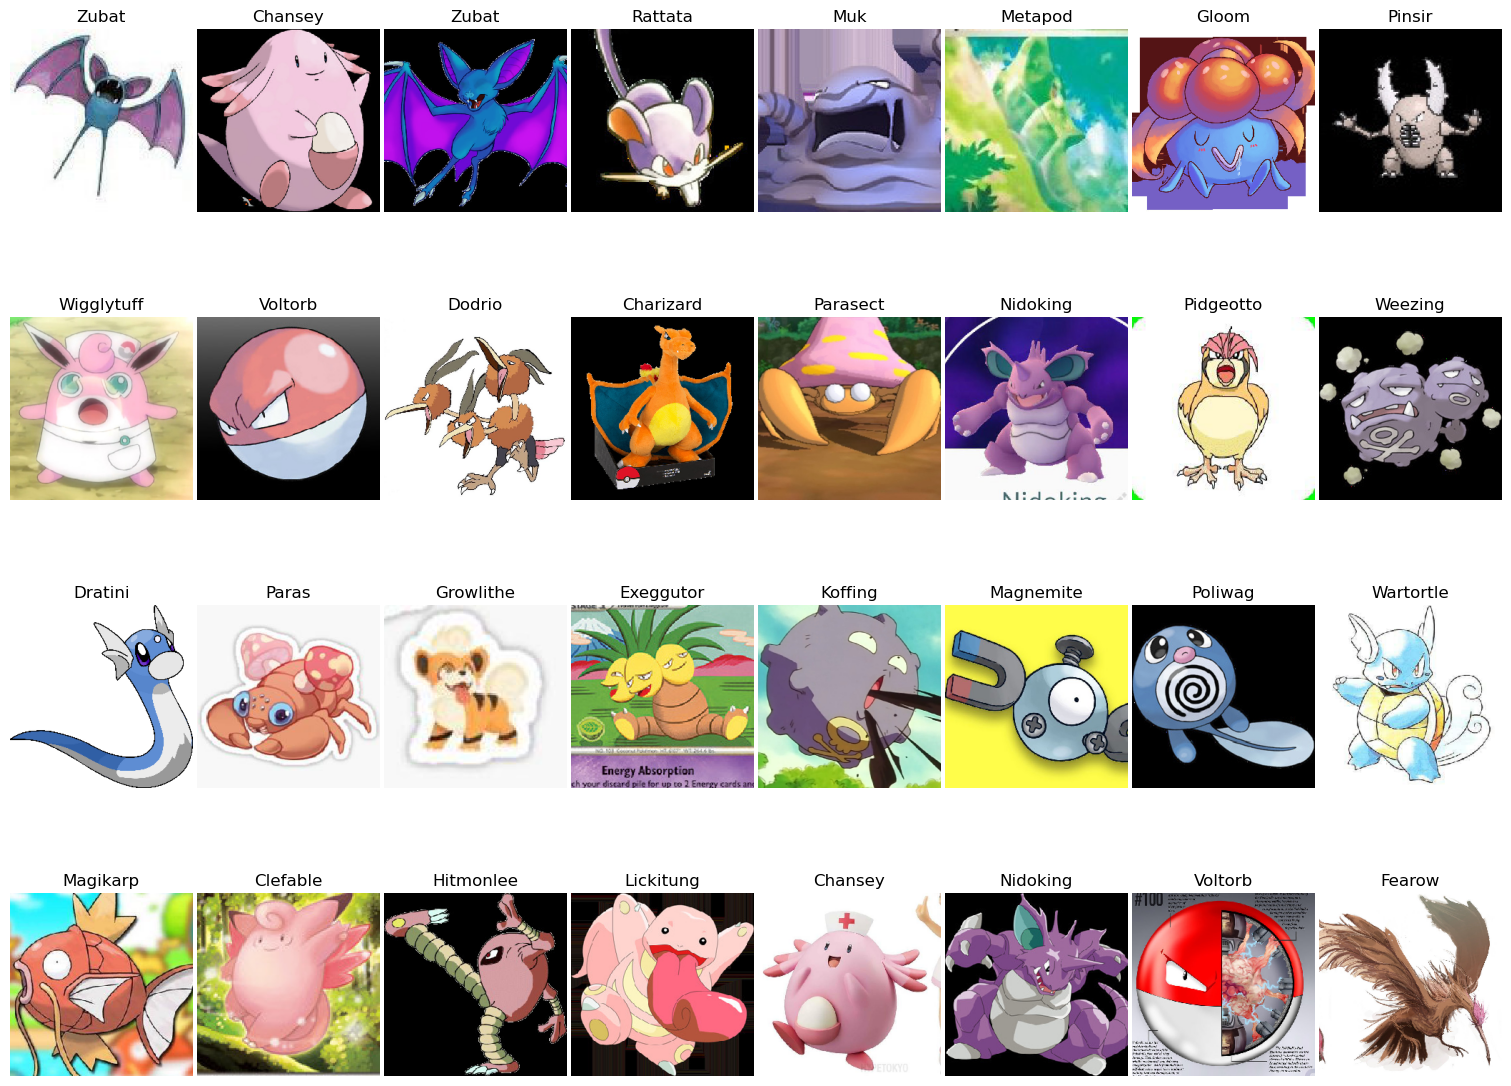

In [5]:
num_images = 1  # Set the number of batches retrieved
row_length = 8  # Set the number of images per row
image_size = (4, 4)  # Set the size of each image

class_labels = train_gen.class_indices
class_labels = {v: k for k, v in class_labels.items()}

for i in range(num_images):
    images, labels = next(train_gen)

    labels = np.argmax(labels, axis=1)
    labels = [class_labels[label] for label in labels]

    plt.figure(figsize=(15, 15)) 

    for j in range(len(images)):
        plt.subplot(32 // row_length + 1, row_length, j + 1)
        plt.imshow(images[j])
        plt.axis('off')
        plt.title(labels[j])
        plt.tight_layout(pad=0.3)

    plt.show()


## Modeling

### Feed-forward Neural Network

I begin by doing transfer learning with DenseNet201, a pre-trained CNN model. I will use DenseNet for feature extraction so I remove the top (fully connected) layers of the model. Overall, this code represents a CNN model where the base model is a pre-trained DenseNet201 network, and additional layers are added to adapt the model for my Pokemon-specific classification task.

In [6]:
from tensorflow.keras.layers import Layer

img_size = 256

base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))

for layer in base_model.layers:
    layer.trainable = False

class CustomGlobalAveragePooling2D(Layer):
    def __init__(self, **kwargs):
        super(CustomGlobalAveragePooling2D, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=[1, 2])

x = base_model.output
x = CustomGlobalAveragePooling2D()(x)
output = Dense(150, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()

In [34]:
tf.keras.utils.get_custom_objects()['CustomGlobalAveragePooling2D'] = CustomGlobalAveragePooling2D

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Filepath for saving best model seen so far
filepath = "model_pokemon.h5"

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only=False)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', 
                               min_delta=0, 
                               patience=5, 
                               verbose=1, 
                               restore_best_weights=True)

# ReduceLROnPlateau callback
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00001)

callbacks_list = [checkpoint, 
                  early_stopping, 
                  learning_rate_reduction]


In [8]:
hist = model.fit(train_gen,
                 validation_data=val_gen,
                 epochs=50,
                 callbacks=callbacks_list)

Epoch 1/50
169/169 [==============================] - ETA: 0s - loss: 3.7092 - accuracy: 0.2912
Epoch 1: val_accuracy improved from -inf to 0.60519, saving model to model_pokemon.h5
169/169 [==============================] - 71s 305ms/step - loss: 3.7092 - accuracy: 0.2912 - val_loss: 2.2982 - val_accuracy: 0.6052 - lr: 0.0010
Epoch 2/50
169/169 [==============================] - ETA: 0s - loss: 1.4969 - accuracy: 0.7877
Epoch 2: val_accuracy improved from 0.60519 to 0.76648, saving model to model_pokemon.h5
169/169 [==============================] - 50s 293ms/step - loss: 1.4969 - accuracy: 0.7877 - val_loss: 1.3729 - val_accuracy: 0.7665 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - ETA: 0s - loss: 0.8008 - accuracy: 0.9066
Epoch 3: val_accuracy improved from 0.76648 to 0.79523, saving model to model_pokemon.h5
169/169 [==============================] - 56s 333ms/step - loss: 0.8008 - accuracy: 0.9066 - val_loss: 1.0521 - val_accuracy: 0.7952 - lr: 0.0010
Epoch 4

## Visualizing Learning Curves

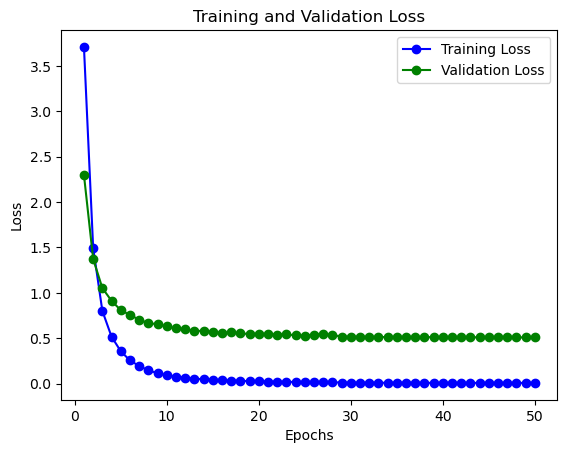

In [9]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

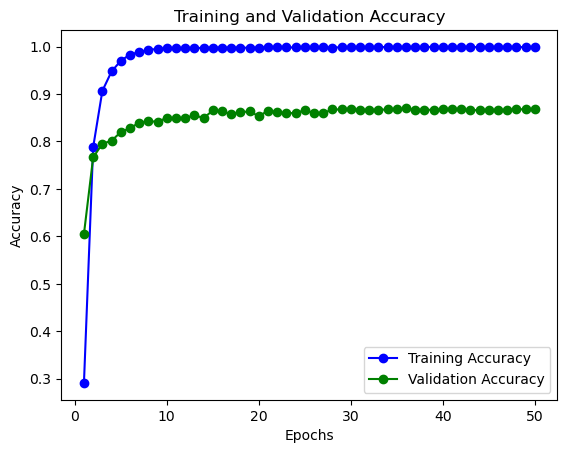

In [26]:
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'go-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We see that the best model which minimizes the loss function has a validation accuracy that is 0.86957. In the code below, I also generate a classification report with one batch of data to confirm this.

In [52]:
import warnings
from sklearn.metrics import classification_report
warnings.filterwarnings("ignore", category=Warning)

best_model = tf.keras.models.load_model('model_pokemon.h5')

# Retrieve one batch of data and labels
batch_data, batch_labels = next(val_gen)

# Make predictions on the batch
batch_predictions = best_model.predict(batch_data)

# Convert the predicted probabilities to class labels
batch_pred_labels = np.argmax(batch_predictions, axis=1)

# Convert the true labels to text labels
class_labels = val_gen.class_indices
class_labels = {v: k for k, v in class_labels.items()}
batch_true_labels_text = [class_labels[label] for label in np.argmax(batch_labels, axis=1)]
val_pred_labels_text = [class_labels[label] for label in batch_pred_labels]

# Generate the classification report
report = classification_report(batch_true_labels_text, val_pred_labels_text)

print(report)


1/1 [==============================] - 3s 3s/step
              precision    recall  f1-score   support

    Clefairy       1.00      1.00      1.00         1
   Dragonite       1.00      1.00      1.00         1
     Dratini       1.00      1.00      1.00         1
     Dugtrio       1.00      1.00      1.00         1
   Electrode       1.00      1.00      1.00         1
     Golduck       1.00      1.00      1.00         1
    Graveler       1.00      1.00      1.00         2
      Grimer       0.00      0.00      0.00         0
    Gyarados       1.00      1.00      1.00         1
  Jigglypuff       1.00      1.00      1.00         1
     Jolteon       1.00      0.50      0.67         2
        Jynx       1.00      1.00      1.00         1
      Kabuto       1.00      1.00      1.00         1
     Koffing       1.00      1.00      1.00         1
      Lapras       1.00      1.00      1.00         1
      MrMime       1.00      1.00      1.00         1
         Muk       0.00      0.

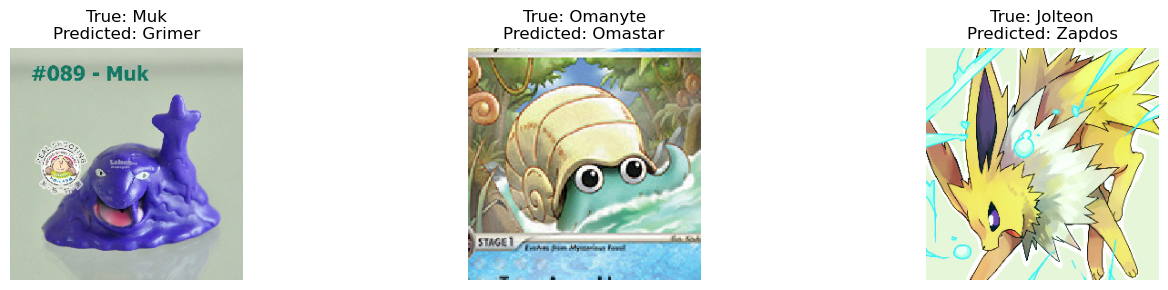

In [53]:
# Visualize wrongly classified images
misclassified_indices = np.where(np.array(val_pred_labels_text) != np.array(batch_true_labels_text))[0]

fig, axes = plt.subplots(1, len(misclassified_indices), figsize=(15, 3))

for i, idx in enumerate(misclassified_indices):
    img = batch_data[idx]
    true_label = batch_true_labels_text[idx]
    pred_label = val_pred_labels_text[idx]

    axes[i].imshow(img)
    axes[i].set_title(f'True: {true_label}\nPredicted: {pred_label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

This is a good result because Muk and Grimer are in the same evolution line and so are Omanyte and Omastar, so it makes sense that the model might have some difficulty distinguishing from the image, as opposed to two completely unrelated pokemon. 

## Using Model for Classification on Pokemon API

In this section, I write some code to request the front-facing image of a Pokemon that is stored in the [RESTful Pokemon API](https://pokeapi.co/) in order to test the model out. I search up `Nidoking` specifically, and the model is able to accurately name it!

In [125]:
import requests
pokemon = 'nidoking' #lower case
url = f'https://pokeapi.co/api/v2/pokemon/{pokemon}'
r = requests.get(url)

print("Name: ",r.json()['name'])
print("Base Experience: ",r.json()['base_experience'])
print("Height: ",r.json()['height'],'m')
print("Weight: ",r.json()['weight'],'kg')

Name:  nidoking
Base Experience:  253
Height:  14 m
Weight:  620 kg


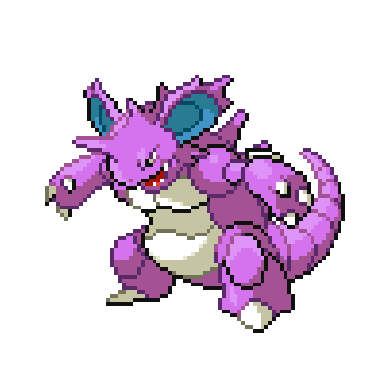

In [126]:
data = r.json()
forms = data["forms"][0]['url']

form_link = requests.get(forms)
content = form_link.json()
image_url = content['sprites']['front_default']

from PIL import Image
from io import BytesIO

response = requests.get(image_url)
image = Image.open(BytesIO(response.content))
image.save("toPredict.png")

plt.imshow(image)
plt.axis('off')
plt.show()

In [127]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

image = load_img("toPredict.png", target_size=(256, 256))
image = img_to_array(image) / 255.0
image = image.reshape(1, 256, 256, 3)

predictions = best_model.predict(image)
class_labels = train_gen.class_indices
class_labels = {v: k for k, v in class_labels.items()}
predicted_label = class_labels[np.argmax(predictions)]
print(predicted_label)

1/1 [==============================] - 0s 69ms/step
Nidoking
